In [21]:
# Install (only if needed) and imports
!pip install -q gdown xgboost lightgbm catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

np.random.seed(42)
RANDOM_STATE = 42

# Team info (edit)
TEAM_CODE = "EM22 "
TEAM_NAME = "Quadra"


In [22]:
import gdown

# file IDs from the URLs you provided
train_id = "1OQWfTaTaRatB8gT3sg723LRtYYKBm5tU"
test_id  = "1MznJKj9_X4TBgnkbMWfBSBv9jyCQ6krd"

gdown.download(f"https://drive.google.com/uc?id={train_id}", "train.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={test_id}", "test.csv", quiet=False)

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")


Downloading...
From: https://drive.google.com/uc?id=1OQWfTaTaRatB8gT3sg723LRtYYKBm5tU
To: /content/train.csv
100%|██████████| 1.32M/1.32M [00:00<00:00, 44.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MznJKj9_X4TBgnkbMWfBSBv9jyCQ6krd
To: /content/test.csv
100%|██████████| 131k/131k [00:00<00:00, 21.7MB/s]


In [23]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())
display(train.info())
display(train['heart_attack_risk'].value_counts(dropna=False))


Train shape: (7963, 26)
Test shape: (800, 25)


,patient_id,age,sex,chol,bp,hr,diabetes,family_history,smoking,obesity,...,sedentary_hr,income,bmi,triglycerides,phys_act_days,sleep_hr,country,continent,hemisphere,heart_attack_risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7963 entries, 0 to 7962
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_id         7963 non-null   object 
 1   age                7963 non-null   int64  
 2   sex                7963 non-null   object 
 3   chol               7963 non-null   int64  
 4   bp                 7963 non-null   object 
 5   hr                 7963 non-null   int64  
 6   diabetes           7963 non-null   int64  
 7   family_history     7963 non-null   int64  
 8   smoking            7963 non-null   int64  
 9   obesity            7963 non-null   int64  
 10  alcohol            7963 non-null   int64  
 11  exercise_hr_wk     7963 non-null   float64
 12  diet               7963 non-null   object 
 13  prev_heart_prob    7963 non-null   int64  
 14  med_use            7963 non-null   int64  
 15  stress_lvl         7963 non-null   int64  
 16  sedentary_hr       7963 

None

,count
heart_attack_risk,
0,5224
1,2739


In [24]:
import pandas as pd

# 1) Split 'bp' like "120/80" into two columns
def split_bp(df):
    if 'bp' in df.columns:
        bps = df['bp'].astype(str).str.split('/', expand=True)
        df['bp_sys'] = pd.to_numeric(bps[0], errors='coerce')
        df['bp_dia'] = pd.to_numeric(bps[1], errors='coerce')
        df = df.drop(columns=['bp'])
    return df

train = split_bp(train)
test = split_bp(test)

# 2) Simple fills: numeric -> median, categorical -> 'Unknown'
num_cols = train.select_dtypes(include=['number']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

for col in num_cols:
    if col in train.columns:
        med = train[col].median()
        train[col] = train[col].fillna(med)  # ✅ no inplace
        if col in test.columns:
            test[col] = test[col].fillna(med)

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')  # ✅ no inplace
    if col in test.columns:
        test[col] = test[col].fillna('Unknown')

# 3) Separate features and target
X = train.drop(columns=['patient_id','heart_attack_risk'])
y = train['heart_attack_risk']
test_ids = test['patient_id']
X_test = test.drop(columns=['patient_id'])

print("Feature columns:", X.columns.tolist())


Feature columns: ['age', 'sex', 'chol', 'hr', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise_hr_wk', 'diet', 'prev_heart_prob', 'med_use', 'stress_lvl', 'sedentary_hr', 'income', 'bmi', 'triglycerides', 'phys_act_days', 'sleep_hr', 'country', 'continent', 'hemisphere', 'bp_sys', 'bp_dia']


In [25]:
# Combine to ensure same dummies
combined = pd.concat([X, X_test], axis=0, ignore_index=True)
combined = pd.get_dummies(combined, drop_first=True)

X = combined.iloc[:len(X), :].copy()
X_test = combined.iloc[len(X):, :].copy()

print("X shape:", X.shape, "X_test shape:", X_test.shape)


X shape: (7963, 48) X_test shape: (800, 48)


In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (6370, 48) Val: (1593, 48)


In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]

metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred, zero_division=0),
    "recall": recall_score(y_val, y_pred, zero_division=0),
    "f1": f1_score(y_val, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_val, y_proba)
}
print(metrics)
print("\nClassification report:\n", classification_report(y_val, y_pred, zero_division=0))


{'accuracy': 0.655367231638418, 'precision': 0.47058823529411764, 'recall': 0.014598540145985401, 'f1': 0.02831858407079646, 'roc_auc': np.float64(0.5008739915482137)}

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1045
           1       0.47      0.01      0.03       548

    accuracy                           0.66      1593
   macro avg       0.56      0.50      0.41      1593
weighted avg       0.59      0.66      0.53      1593



Saved metrics image: EM22 _Quadra_Task1_Metrics.png


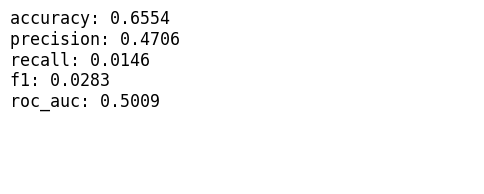

In [28]:
# Save a PNG with the metric values (Team naming rule)
metrics_png_name = f"{TEAM_CODE}_{TEAM_NAME}_Task1_Metrics.png"

fig, ax = plt.subplots(figsize=(6,2))
ax.axis('off')
txt = '\n'.join([f'{k}: {v:.4f}' for k,v in metrics.items()])
ax.text(0, 0.5, txt, fontsize=12, family='monospace')
plt.savefig(metrics_png_name, bbox_inches='tight')
print("Saved metrics image:", metrics_png_name)


In [29]:
test_pred = clf.predict(X_test)
output = pd.DataFrame({"patient_id": test_ids, "heart_attack_risk": test_pred})

pred_csv_name = f"{TEAM_CODE}_{TEAM_NAME}_Task1_Predictions.csv"
output.to_csv(pred_csv_name, index=False)
print("Saved predictions:", pred_csv_name)
display(output.head())


Saved predictions: EM22 _Quadra_Task1_Predictions.csv


,patient_id,heart_attack_risk
0,VRK5064,0
1,NEN2365,0
2,KXT2493,0
3,TKO0406,1
4,GDP2405,0


In [38]:
# Check the current working directory
!pwd
!ls
# from google.colab import files
files.download("EM22 _Quadra_Task1_Predictions.csv")



/content
'EM22 _Quadra_Task1_Metrics.png'       sample_data   train.csv
'EM22 _Quadra_Task1_Predictions.csv'   test.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>